<a href="https://colab.research.google.com/github/karabash/.NEtFinalExam/blob/master/Inl%C3%A4mning_Lab4_Clustering_and_Association_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4 - Klustring och Associationsanalys 


<p>I denna labb ska ni använda två olika typer av oövervakad inlärning för att analysera transaktionsdata.</p>
<ol>
<li>
I del 1 kommer ni analysera data från genom så kallad RFM analysis, vi kommer genomföra analysen med hjälp a en K-means modell i Python för att klustra data beroende på det mönster som uppvisas i data, baserat på just RFM.</li>

<li>I del 2 ska ni få testa på associationsanalys genom att  analysera transaktionsdata från matvaruhandeln, närmare bestämt för en butik kallad *MatFörAlla* för att på detta sätt komma med råd för hur de bör organisera sin butik för att öka försäljningen. </li>
</ol>
<p>Till skillnad från flera av de tidigare laborationerna kommer fokus här inte vara så mycket på programmeringen, utan mycket kod kommer redan finnas i laborationen. Fokus är snarare på att förstå de bakomliggande mekanismerna i denna typ av dataanalys som skiljer sig från de vi tidigare tittat på. </p>

<p style="color:red;">A red paragraph De frågor ni ska besvara är märkta med **F#nummer**, vissa frågor kräver kodning, medan andra inte gör det. Det finns också uppgifter som inte behöver besvaras i text utan enbart med kodning, även dessa är dock märkta **F#nummer**. Vissa frågor inkluderar flera frågor/uppgifter, dessa är markerade med bokstäver under sin fråga.</p> 

Ex.

**F2** 
>
>a. Är det någon av dessa krav som **inte** är uppfyllda? Motivera svaret.
>
>b. Hantera eventuella nullvärden på lämpligt sätt.


<h1><strong>Del 1 Klustring</strong></h1>

Inspirerad av: Khalid i Towards Data Science

I denna del av laborationen ska ni använda ett dataset med data från en onlineaffär för att lista ut vilka olika kunder ni har- Vilka är exempelvis lojala kunder,som ni bör ägna extra energi åt, och vilka är sådana som bara handlar någon enstaka gång och som det inte är värt att lägga tid och pengar på? Vi ska alltså segmentera våra kunder baserat på några olika kriterier. Själva segmenteringen kommer vi utföra med K-means clustering. 

Det finns många olika sätt att segmentera kunder på, några man kan tänka sig är:

* Demografiskt - ålder, kön etc. Demographic — age, gender, socioeconomic status
* Geografiskt - var de bor.
* **Beteendemässigt - vad gör dina kunder på din sida?** 

I denna laboration  ska vi segmentera kunder baserat på beteende. Ett vanligt sätt att fånga beteende är genom så kallad RFM segmentering, vilket innebär att kunder segmenteras baserat på tre kriterier nämligen *Recency, Frequency and Monetary*, alltså **RFM**. 

* **Recency** - Antalet dagar sedan en kund köpte något.
* **Frequency** - Hur ofta en kund handlar
* **Monetary** - För hur mycket har kunden handlat för?





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
from google.colab import drive
try:
    from google.colab import drive
    drive.mount("/content/drive/", force_remount=True)
    google_drive_prefix = "/content/drive/My Drive"
    data_prefix = "{}/mnist/".format(google_drive_prefix)
except ModuleNotFoundError: 
    data_prefix = "data/"
drive.mount('/content/drive')

Mounted at /content/drive/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/MyDrive/lab4')
!pwd

/content/drive/MyDrive/lab4


<h2>F1</h2> Ni hämtar själva det dataset ni ska använda [här](https://archive.ics.uci.edu/ml/datasets/online+retail) där finns också värdefull information om kvaliteten på detta dataset. Läs sedan in ert dataset med hjälp av Pandas. (**OBS!** Det är inte en csvfil utan en excelfil som ni laddar ner.)

In [4]:
df = pd.read_excel("/content/drive/MyDrive/lab4/OnlineRetail.xlsx")


In [5]:
# DataFrame.notNa() -> Detect existing (non-missing) values.
df = df[df['CustomerID'].notna()]

Vi kommer inte använda hela detta dataset då det är extremt stort, vilket gör att det blir för tungt att arbeta med. Istället väljer vi ut 10000 rader som får representera våra kunders beteende. Detta görs i koden nedan.

In [6]:
#sequence: Can be a list, tuple, string, or set.
#k: An Integer value, it specify the length of a sample.
#Returns: k length new list of elements chosen from the sequence.

df_fix = df.sample(10000, random_state = 42)
df_fix.shape

(10000, 8)

In [7]:
df_fix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 47912 to 282657
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    10000 non-null  object        
 1   StockCode    10000 non-null  object        
 2   Description  10000 non-null  object        
 3   Quantity     10000 non-null  int64         
 4   InvoiceDate  10000 non-null  datetime64[ns]
 5   UnitPrice    10000 non-null  float64       
 6   CustomerID   10000 non-null  float64       
 7   Country      10000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 703.1+ KB


Som vanligt behöver vi först bekanta oss med den data vi har tillgänglig och även kontrollera om vi behöver åtgärda något innan vi påbörjar analysen. 

<strong>Följande punkter är krav</strong> som behöver säkerställas för att K-means ska fungera på ett dataset. 

* **Inga nullvärden** K-means kan inte hantera nullvärden överhuvudtaget så de måste antingen ersättas eller så måste hela raden tas bort. 



In [8]:
#det finns ingen null värde
nulls = df_fix.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    print(index, row[0])

InvoiceNo 0
StockCode 0
Description 0
Quantity 0
InvoiceDate 0
UnitPrice 0
CustomerID 0
Country 0


* **Endast numeriska värden.** Eftersom K-means använder distans som beräkningssätt för att hitta kluster fungerar inte kategoriska variabler. Dessa behöver därför ersättas, antingen med numeriska värden, om de tillhör ordnialskala (och därmed har ordning) eller med dummyvariabler om de tillhör nominalskala och alltså inte har någon ordning. Mycket viktigt att inte distanser förändras!

<h4><strong>Done</strong></h4>

In [9]:
df_fix.drop(columns=['Description', 'Country']).head(5)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
47912,540456,48185,2,2011-01-07 12:14:00,7.95,13534.0
342630,566891,23013,4,2011-09-15 13:51:00,3.95,14894.0
288183,C562139,21313,-4,2011-08-03 10:10:00,0.85,12921.0
325368,565438,22382,4,2011-09-04 13:56:00,1.65,17229.0
331450,566016,21212,24,2011-09-08 12:20:00,0.55,15144.0


* **Inga outliers eller brus.** K-means är väldigt känslig för detta eftersom algoritmen fungerar genom att beräkna avstånd.

In [10]:
from datetime import datetime,timedelta

df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

Q1 = df_fix.quantile(0.25)
Q3 = df_fix.quantile(0.75)
IQR = Q3 - Q1
#Any value away from this lower and upper bound value is consider as outlier.
df_fix[((df_fix < (Q1 - 1.5 * IQR)) |(df_fix > (Q3 + 1.5 * IQR))).any(axis=1)]

#remove outlier
df_fix = df_fix[~((df_fix < (Q1 - 1.5 * IQR)) |(df_fix > (Q3 + 1.5 * IQR))).any(axis=1)]
df_fix.shape

#1507 outliers -> 10000- 1497 = 1507

(8493, 8)

* **Det finns ingen/liten korrelation mellan variablerna** Korrelerade variabler är att betrakta som brus och är inte meningsfulla för algoritmer som ska dela in data i olika segment eftersom de representerar samma karaktäristik hos ett segment. Variabler med hög korrelation mellan varandra bör alltså inte båda inkluderas.

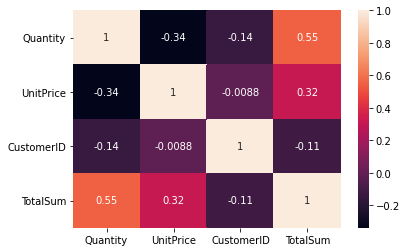

In [15]:
corrMatrix = df_fix.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()




In [16]:
filter_df = corr_matrix[(corr_matrix >= 0.75) & (corr_matrix == 1)]
plt.figure(figsize=(30,10))
sb.heatmap(filter_df, annot=True, cmap="Reds")
plt.show()

NameError: ignored

* **Inte för många dimensioner.** När antalet dimensioner (variabler) ökar, kommer distansen mellan alla variabler att konvergera till ett konstant värde mellan vilka variabler som helst, därmed kan man inte längre urskilja några kluster. Ju fler dimensioner, desto svårare att hitta kluster alltså.

<h3>F2</h2> 

>
>a. Är det någon av dessa krav som **inte** är uppfyllda? Motivera svaret.
> Förvånads värt mycket är string. 
> Länder borde gå att göra om till nummer men behövs inte.
> Hitta ´t ganska mycket outliers som skapar jätte skumma bilder invoices med Quantity över 12000 och prices på ca 1750...

>b. Hantera eventuella nullvärden på lämpligt sätt som gör att ni 
> Fick ca 2500 Nan på "CustomerId" vilket jag tyckte var märkligt.
>Ändrade 'random_state = 41' (närmsta primtal) och alla försvann. Oddsen är små att det är primtalets fel utan snarare något relaterat till datorn, alltså att datorn genererade fel känns större.


### RFM

För att segmentera våra kunder ka vi alltså använda RFM,vilket betyder att vi behöver skapa dessa features (kolumner) för att kunna klustra dem i enlighet med dessa. Vi behöver såklart utgå från det data vi har för att skapa dessa tre kolumner. Detta görs i koden nedan. 

**F3** Kommentera koden så att det är förståeligt vad som händer. 

In [17]:
#importing datetime api
#datetime.datetime class helps us for uppling classes for manipulating dates and times in both simple and complex ways.
#datetime.timedelta cöass helps is expressing the difference between two date, time, or datetime instances to microsecond resolution.
from datetime import datetime,timedelta
#df_fix["InvoiceDate"].dt.date takes only date and initialize back into df_fix["InvoiceDate"]
#df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

#creating total sum column and initiliaze every column line after making multiplication
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

#as I've written on line 6 InvoiceDate column contains only date and line 12 create date instance for records recency
snapshot_date = max(df_fix.InvoiceDate) + timedelta(days=1)

# making aggregation for df_fix - each customer because dataframe missing as TotalSum, InvoiceNo
customers = df_fix.groupby(['CustomerID']).agg({
   'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})
#Rename column names
customers.rename(columns = {'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalSum': 'MonetaryValue'}, inplace=True)

In [ ]:
#df_fix["InvoiceNo"]

Q1 = customers.quantile(0.25)
Q3 = customers.quantile(0.75)
IQR = Q3 - Q1
#Any value away from this lower and upper bound value is consider as outlier.
customers[((customers < (Q1 - 1.5 * IQR)) |(customers > (Q3 + 1.5 * IQR))).any(axis=1)]

#remove outlier
customers = customers[~((customers < (Q1 - 1.5 * IQR)) |(customers > (Q3 + 1.5 * IQR))).any(axis=1)]
customers.shape

#1507 outliers -> 10000- 1497 = 1507

(1693, 3)

Förutom de krav som diskuterats ovan kräver också K-mean att följande två krav är uppfyllda:

* **Symetrisk distribution av variabler i data (ingen skevhet).** Transformering av data till en normal distribution medför att outliers och brus från mindre påverkan. 

* **Variabler i samma skala** — Alltså ha samma medelvärde och varians, vanligtvis vill man ha värden mellan -1 till 1 (standardiserad data) eller mellan 0 till 1 (normliserad data). För att K-means ska behandla alla attribut som likvärdiga måste de ha samma skala. 

I nedanstående kodblock följer en ananlys för att ta reda på hur våra RFM-variabler ser ut när det gäller skevhet, standardisering och normalfördelning.

Vi startar med att titta på hur de tre variablerna ser ut.

In [ ]:
customers.describe()

,Recency,Frequency,MonetaryValue
count,1693.000000,1693.000000,1693.000000
mean,133.452451,1.593030,19.897112
std,106.826131,0.731186,14.939894
min,1.000000,1.000000,-19.800000
25%,41.000000,1.000000,8.830000
50%,97.000000,1.000000,16.350000
75%,213.000000,2.000000,30.000000
max,374.000000,3.000000,61.360000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

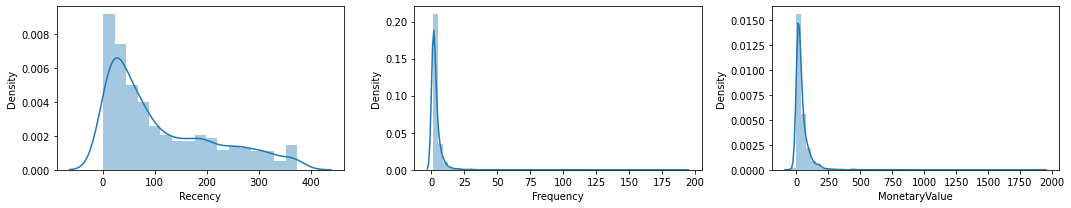

In [18]:
#Visualisera distributionen av data i våra tre variabler 
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(customers['Recency'], ax=ax[0])
sns.distplot(customers['Frequency'], ax=ax[1])
sns.distplot(customers['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

**F4** Hur ser vår data ut? Är de tre variablernas distribution symetrisk eller skev?

För att ytterligare undersöka skevheten kan vi också använda pandas inbyggda funktion för det `pd.skew()`. 

Det går inte att säga exakt vilket värde som reflekterar symmentri även fast man tycka att ett värde på 0 torde göra det, men  det kan också implicera att den ena sidan är "tjock" och den andra "tunn". En tumregel är dock att ett positivt värde indikerar en positiv skevhet, (alltså att värdena tenderar att vara fler över 0 jämfört med under 0) medan ett negativt värde indikerar en negativ skevhet.

Anledningar till skevhet kan vara outliers, men det behöver inte vara så. 

In [19]:
print(customers['Recency'].skew().round(2))
print(customers['Frequency'].skew().round(2))
print(customers['MonetaryValue'].skew().round(2)) 


0.93
15.19
11.11


**F5** Följande kod hanterar de problem som finns gällande skevheten i de tre variablerna. 

>
> a. Hur har skevheten hos de tre variablerna förändrats efter transformeringen? 
>
>b. Vilka metoder för att åtgärda skevhet har används för de tre variablerna? Varför har inte samma metod använts för alla variabler? 

In [20]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2455,7.755753,0.581015,3.408514
2456,1.266672,1.303684,5.397095
2457,4.261552,0.581015,-1.669108
2458,1.660829,1.509441,4.112041
2459,7.141308,0.834807,3.673193


In [21]:
print(customers_fix['Recency'].skew().round(2))
print(customers_fix['Frequency'].skew().round(2))
print(customers_fix['MonetaryValue'].skew().round(2)) 

-0.1
0.18
0.14


Vi behöver också se till att kravet på variablerna att befinna sig i samma skala uppfylls. Det innebär att vi behöver standardisera våra data (efter att vi tagit hand om skevheten i koden ovan). 

**F6** 

>
>a. Utför standardisering med hjälp av`StandardScaler` 
>
>b. Visualisera resultatet
>
>c. Varför är det så viktigt i K-means att denna pre-processing görs?
>
>d. Vad för struktur är customers_normalized?

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[ 0. -0.  0.]
[1. 1. 1.]


Nu är det dags att testa att använda K-means för att segmentera våra kunder

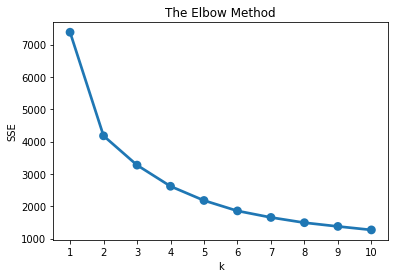

In [23]:
from sklearn.cluster import KMeans

sse = {} #sum of squared error
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

**F7** 

>a. Vilket k är lämpligast enligt armbågsmetoden? Varför?
>
>b. Fyll i detta tal i nedanstående kod som skapar modellen genom att ersätta punkterna med rätt siffra.

In [24]:
model = KMeans(n_clusters= 3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2460,)

### Vad säger vår modell?

För att undersöka vad vi fått för kluster kan vi räkna ut medelvärdena för våra skapade kluster. Först lägger vi dock till en kolumn för våra kluster i vår dataframe.

Vi kan också visualisera våra kluster för att få en tydligare bild av dem.

>
>a. Vad säger dessa värden om våra kunder?
>
>b.Vad betyder värdena i den sista kolumnen, som också är ny?
>
>c. Vad säger visualiseringen?
>
>d.Baserat på vad vi nu vet, döp de kluster som skapats till lämpliga namn och skriv en kort rekommendation till butiken hur de bör hantera dem.

In [25]:
customers["Cluster"] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,40,5,133.20,1
12352.0,73,5,80.85,1
12354.0,233,1,17.40,2
12357.0,34,3,176.28,1
12359.0,58,2,38.14,0


In [26]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          45.1       1.6          15.2   705
1          46.7       7.1          88.8   840
2         223.6       1.6          21.7   915

In [27]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,-0.502201,1.094606,1.623870,12347.0,1
1,-0.020369,1.094606,1.015429,12352.0,1
2,1.144648,-1.118093,-0.331140,12354.0,2
3,-0.620259,0.582085,2.012444,12357.0,1
4,-0.213315,0.065210,0.270973,12359.0,0


In [28]:
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347.0,1,Recency,-0.502201
1,12352.0,1,Recency,-0.020369
2,12354.0,2,Recency,1.144648
3,12357.0,1,Recency,-0.620259
4,12359.0,0,Recency,-0.213315


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


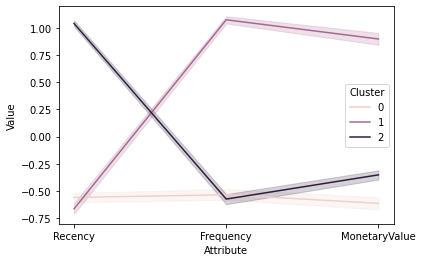

In [29]:
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

*Skriv din rekommendation för de namngivna klustren i denna markdown,ersätt denna text.*

<strong><h1>Del 2 Associationsanalys </strong></h1>

Inspirerad av: David Johnsson

Associationsanalys är en oövervakad analysmetod som går ut på att hitta relationer i data. Ett open source bibliotek som har funktioner för att hantera associationsanalys är exempelvis `mlxtend` som vi kommer använda ilaborationen. Läs mer om `mlxtend` [här](https://rasbt.github.io/mlxtend/). 

### Importera bibliotek och läs in data 

In [30]:
import csv
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib
%matplotlib inline

In [98]:
with open("groceries.csv") as groceries_file:
   dataset = list(csv.reader(groceries_file))

In [99]:
   dataset 

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'],
 ['tropical fruit', 'yogurt', 'coffee'],
 ['whole milk'],
 ['pip fruit', 'yogurt', 'cream cheese ', 'meat spreads'],
 ['other vegetables',
  'whole milk',
  'condensed milk',
  'long life bakery product'],
 ['whole milk', 'butter', 'yogurt', 'rice', 'abrasive cleaner'],
 ['rolls/buns'],
 ['other vegetables',
  'UHT-milk',
  'rolls/buns',
  'bottled beer',
  'liquor (appetizer)'],
 ['pot plants'],
 ['whole milk', 'cereals'],
 ['tropical fruit',
  'other vegetables',
  'white bread',
  'bottled water',
  'chocolate'],
 ['citrus fruit',
  'tropical fruit',
  'whole milk',
  'butter',
  'curd',
  'yogurt',
  'flour',
  'bottled water',
  'dishes'],
 ['beef'],
 ['frankfurter', 'rolls/buns', 'soda'],
 ['chicken', 'tropical fruit'],
 ['butter', 'sugar', 'fruit/vegetable juice', 'newspapers'],
 ['fruit/vegetable juice'],
 ['packaged fruit/vegetables'],
 ['chocolate'],
 ['specialty bar'],
 ['other vegetables'],
 ['butter milk

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


F1. Ta reda på hur filen ser ut genom att öppna den i en vanlig text editor. Fundera sedan på varför vi inte kommer läsa in den i en dataframe som vi ofta gjort hitills.

>
>a.Vad för typ av data innehåller filen? 
>
>b.Varför är det olämpligt att använda en dataframe för att läsa in filen?
>

Istället för en dataframe kommer vi läsa in filen i en så kallad sparse matrix som vi sedan kan titta på med en dataframe. Nedan är ett exempel på en sparse matrix för 3 olika kunder som köpt 3 produkter var. Varje produkt som finns får sin egen kolumn medan varje rad representerar en shoppingvagn som någon kund köpt. 


| &nbsp; | Produkt 1 | Produkt 2 | Produkt 3 |
|:------:|:---------:|:---------:|:---------:|
| Kund 1 |     0     |     0     |     1     |
| Kund 2 |     1     |     1     |     0     |
| Kund 3 |     0     |     1     |     0     |


>
>c. Vad är fördelen med att använda en sparse matrix jämfört med att läsa in .csv-filen som den är?
>
>d. Vad finns det för nackdel?
>
>e. Hur ser matrisen ut i jämförelse med .csv-filen?


I `mlxtend` finns en `TransactionEncoder()` klass för att skapa en sparse matrix av vår .csv-fil. Nedan kod uför detta.

>
>f. Kommentera koden nedan så att man förstår vad som händer.
>

<h3>a</h3>


In [33]:
type(dataset)

list

<h3>b</h3>
<p>alla values är list och inte kateforiserat med sitt eget column t.ex dricka, cake with socker, cake without socker. Det kommer att ta tid att grupera allt sen fillna med 0 eller 1. När vi analyserar data jobbar vi mest siffror inte med string. Dvs 2d arrays och det finns hurmånga index som helst. arrat[0][0]
array[1][0] [n][0]</p> Det på minner linkedlist

C 

Storage: There are lesser non-zero elements than zeros and thus lesser memory can be used to store only those elements.
Computing time: Computing time can be saved by logically designing a data structure traversing only non-zero elements.
When storing and manipulating sparse matrices on a computer, it is beneficial and often necessary to use specialized algorithms and data structures that take advantage of the sparse structure of the matrix.

Sparse data is by nature more easily compressed and thus requires significantly less storage. 

Storing the Sparse Ma

</p>


d 


Begränsat minne
Begränsad bearbetningskraft (cpu)
Kombination som gör det omöjligt att köra algoritmer ibland eller gör det riktigt långsamt. Du kan dock utvärdera situationen.

Memory: Even though the majority of elements are zero and has no information, space is utilized to store it and needs a way to handle it.
Computational: To perform any calculations like matrix multiplication might take a lot of time due to although we know the result is 0. It has to still perform the process and time is wasted.

e


df[0][0] ger -> citrus fruit semi-finished bread margarine ready soups

på excel [1][A] ger -> citrus fruit semi-finished bread margarine ready soups

dvs samma

In [34]:
import csv

f = open('groceries.csv')

data = []
for line in f:
    data_line = line.rstrip().split('\t')
    data.append(data_line)


print(type(data))

data = pd.DataFrame(data)
data.head(1)
print(df.head(1))
print("xxxxxxxxxxxxxx")
print(dataset[0][0])


<class 'list'>
  InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom

[1 rows x 8 columns]
xxxxxxxxxxxxxx
citrus fruit


In [35]:
#Encoder class for transaction data in Python lists
#transform list into logicalframe
te = TransactionEncoder()
'''For categorical variables where no such ordinal relationship exists, the integer encoding is not enough.
In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).
In this case, a one-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.
In the “color” variable example, there are 3 categories and therefore 3 binary variables are needed. A “'''

te_ary = te.fit(dataset).transform(dataset)

#building the data frame rows are logical and columns are the items have been purchased 
groceries = pd.DataFrame(te_ary, columns=te.columns_)
groceries.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,...,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,sound storage medium,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


### Summera och inspektera transaktionerna. 

Som vanligt behöver vi göra oss familiära med den data vi har, innan vi kan påbörja arbetet med att generera associationsregler.

**F2** Använd lämpliga funktioner som ni lärt er i tidigare laborationer för att skapa en bild av hur er sparse matrix ser ut, besvara också följande frågor. 
>
>a. Beräkna densiteten på matrisen. TIPS! För att beräkna densiteten behöver ni veta hur många värden som innehåller `True` respektive `False`.
>
>b. Hur många produkter finns i ert dataset?
>
>c.Hur många transaktioner finns i ert dataset?
>
>d.Vilka är de 10 vanligaste produkterna i ert dataset? Svaret ska ges i form av en lista med strängar ex. `["potatis", "köttbullar", mjölk,..]`
>
>e.Hur många transaktioner innehåller produkten "soda"?
>
>f.Hur många transaktioner innehåller endast en produkt?
>
>g.Hur många produkter är det i den transaktion som innehåller flest produkter?
>

In [100]:
#a
#groceries.values.sum()
#(~groceries).values.sum()
(~groceries).values.sum()+groceries.values.sum()


1662115

In [74]:
#b
len(groceries.columns)


169

In [ ]:
#c Hur många transaktioner finns i ert dataset?
groceries.info(verbose=True)


In [122]:
'''D'''
#Vilka är de 10 vanligaste produkterna i ert dataset? Svaret ska ges 
#i form av en lista med strängar ex. ["potatis", "köttbullar", mjölk,..]

# Konverterar jag True till 1 för produkt som köptes och  false till 0.
from itertools import islice

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1    

groceries = groceries.applymap(encode_units)
df_sum = groceries.sum().sort_values(ascending=False)
ten = list(islice(df_sum.keys(), 10))
print(ten)


#Rasmus
#col = list(groceries.columns) 
#df1['cols'] = np.asarray(col)'''

['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt', 'bottled water', 'root vegetables', 'tropical fruit', 'shopping bags', 'sausage']


"Rasmus col = list(groceries.columns) \ndf1['cols'] = np.asarray(col)"

In [166]:
'''E'''
#Hur många transaktioner innehåller produkten "soda"?
res = groceries.sum(axis=1).sort_values(ascending=True)
x = (groceries.iloc[8:169] == 1).sum().sort_values(ascending=False)
print(x.get('soda'))


#Rasmus
#col = list(groceries.columns)
#df1 = pd.DataFrame()
#df1['cols'] = np.asarray(col)

#l = list()
#for i in col:
   #l.append(groceries[i].values.sum())
   # print(groceries[i].values.sum())
#m = np.asarray(l)
#df = df.drop(['0'],axis=1)
#df1['freq'] = m
#df1.nlargest(10, ['freq'])'''






26


In [167]:
'''f'''
#Hur många transaktioner innehåller endast en produkt?



print(x.get('yogurt'))


18


In [158]:
groceries.describe()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,...,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,sound storage medium,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
count,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,...,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000
mean,0.008033,0.033452,0.003559,0.003254,0.000610,0.000102,0.000407,0.017692,0.002745,0.052466,0.033249,0.026029,0.080529,0.110524,0.004169,0.064870,0.055414,0.027961,0.013218,0.008948,0.029893,0.077682,0.015048,0.003254,0.010778,0.023284,0.005694,0.021047,0.042908,0.049619,0.009049,0.082766,0.005084,0.011388,0.002237,0.058058,0.010269,0.002542,0.002745,0.001322,...,0.037824,0.005491,0.093950,0.014235,0.017692,0.098526,0.003559,0.024504,0.003050,0.002644,0.174377,0.017082,0.005491,0.000102,0.006812,0.005592,0.027351,0.008541,0.030402,0.003660,0.001729,0.005186,0.011185,0.033859,0.009049,0.003254,0.003864,0.002339,0.000712,0.104931,0.008134,0.006507,0.038434,0.071683,0.000813,0.042095,0.019014,0.255516,0.139502,0.006914
std,0.089268,0.179823,0.059552,0.056951,0.024693,0.010084,0.020164,0.131836,0.052326,0.222976,0.179294,0.159231,0.272124,0.313557,0.064435,0.246309,0.228799,0.164871,0.114213,0.094173,0.170301,0.267684,0.121751,0.056951,0.103261,0.150812,0.075247,0.143549,0.202660,0.217167,0.094701,0.275542,0.071124,0.106110,0.047245,0.233865,0.100822,0.050356,0.052326,0.036335,...,0.190780,0.073899,0.291774,0.118464,0.131836,0.298039,0.059552,0.154617,0.055148,0.051351,0.379453,0.129583,0.073899,0.010084,0.082260,0.074576,0.163113,0.092026,0.171698,0.060393,0.041542,0.071828,0.105169,0.180875,0.094701,0.056951,0.062042,0.048305,0.026670,0.306481,0.089827,0.080409,0.192252,0.257975,0.028510,0.200815,0.136580,0.436173,0.346487,0.082867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [173]:
#g hur många produkter är det i den transaktion som innehåller flest produkter?


# Defining the hot encoding function to make the data suitable  
# for the concerned libraries 
print(x.idxmax(), x.max())

whole milk 43


### Frekvensen av produkter 

**F3** Följande funktion `item_frequency()` beräknar antalet av en viss produkt i förhållande tilldet totala antalet transaktioner i %. 

>
>a. Använd denna  funktion (alltså anropa funktionen, gör inga ändringar i själva funktionen) för att beräkna frekvensen av följande produkter: "whole milk", "butter", "rice". 
>
>b. Använd funktionen för att beräkna frekvensen av de produkter som finns på rad 4,5 och 6. 
>



In [ ]:
def item_frequency(dataset):
    return dataset.sum() / len(dataset) * 100

item_frequency(groceries)

Mer intressant för vår kommande analys är att veta vilka produkter som förekommer fler gånger än ett visst bestämt värde vilken kallas support. 

**F4** Definiera en funktion `item_frequency_plot` som tar ett dataset och ett supportvärde som parametrar och returnerar dessa produkter och deras frekvens i %.

In [ ]:
def item_frequency_plot(dataset, support): 
    
    #er kod här

SyntaxError: ignored

**F5** Använd din funktion för att plotta ut de produkter som har en support på minst 0.125 i ett stapeldiagram. (TIPS! använd koden nedan och skicka endast med de korrekta parametrarna för att skapa ett stapeldiagram.

In [ ]:
_ = item_frequency_plot().plot.bar()

NameError: ignored

## Extrahera associationsregler 

*MatFörAlla* börjar bli otåliga och tycker att er analys hitills endast visat på saker de redan vet. De vill att ni ska ta fram ny kunskap somär till nytta för dem om deras kunder.

Det är därmed dax att extrahera associationsregler för att kunna hjälpa *MatFörAlla* att placera sina produkter rätt i butiken. 

Det finns tre olika typer av associeringsregler:*Trivial*, *Unexplainable* och *Actionable* 

* Actionable - Målet med en market basket analysis är qtt hitta associationer som går att agera på, alltså som ger användbar information.  
* Trivial - Regler som är uppenbara och därmed inte intressanta. 
* Unexplainable - Sambandet som regeln står för går inte att förklara utan ytterligare forskning. 

**F6**

>
>a. Förklara varje regeltyp, vad innebär de för vårt arbete? Ge exempel på de tre regeltyperna utifrån domänen matvaruhandel.
>
>b. Ge ett exempel på varje regel utifrån den data ni har fått av *MatFörAlla*
>
>

För att förenkla hur vi kommunicerar kring assosiationsregeler använder vi följande standardiserade sätt att beskriva dem:

$Antecedent \rightarrow Consequent$.

Exempel:

$Toys, wrapping paper \rightarrow Batteries$ 

Ovanstående tolkas som att om du köper leksaker och inslagningspapper ($Antecedent$) är det troligt att du också köper batterier ($Consequent$)


### Att mäta associeringsregler 

För att ta reda på vilka associationsregler som är värdefulla krävs mycket domänkunskap. Det finns dock också några mätvärden som kan användas för att hjälpa till att avgöra kvaliteten på reglerna och för att veta hur mycket vikt vi bör lägga vid en specifik regel. 

Det finns tre huvudsakliga sätt att mäta associeringsregler:

**Support**

Support är antalet transaktioner som innehåller ett specifierat antal produkter. Ju oftare dessa produkter förekommer gemensamt (alltså idetta fallet köpts gemensamt) desto större blir vikten av supporten.

Om transaktionsdata ser ut enligt följande:

```
t1: Beef, Carrot, Milk
t2: Steak, Cheese
t3: Cheese, Flingor
t4: Steak, Carrot, Cheese
t5: Steak, Carrot, Butter, Cheese, Milk
t6: Carrot, Butter, Milk
t7: Carrot, Milk, Butter
```

Skulle supporten för att kombinationen morötter, smör och mjölk köps tillsammans se ut enligt följande:

$$Support(Carrot \land Butter \land Milk) = \frac{3}{7} = 0.43$$

detta på grund av att en kombination av dessa tre produkter förekommer 3 gånger av 7 möjliga transaktioner. 

**Confidence**

Konfidens innebär att om vi har en regel som säger följande:  $Beef, Chicken \rightarrow Apple$ med en konfidens på 33%, så innebär det att om det finns biff och kyckling i någons shoppingvagn så är det 33% chans att det också finns äpplen. 

Konfidensen beräknas exempelvis såhär: 

Givet följande regel: $Butter \rightarrow Milk, Chicken$

$$Butter \rightarrow Milk, Chicken = \frac{Support (Butter \land Milk \land Chicken)}{Support (Butter)}$$

**Lift**

Lift ger oss ett mätvärde på hur bra en regel är, baserat enbart på den högra sidan av en regel(alltså $Consequent$). Detta innebär att exempelvis regler som inkluderar vanliga produkter som $Consequent$ så kommer reglen inte säga någoting av värde. Det är alltså inte meningsfullt att ha mjölk, som är en väldigt vanlig produkt, på den högra sidan i en regel. 

Tumregeln för Lift är följande: 

Om Lift är  $>1$  så är regeln bättre än att gissa.Om Lift är $\leq1$ så är regeln ungefär likvärdig med en ren gissning. 


Exempel:

$$Chicken \rightarrow Milk = \frac{Support (Chicken \land Milk)}{Support(Chicken) \times Support (Milk)} = \frac{(4 / 7)}{(5 / 7) \times (4 / 7)} = 1.4$$

Detta implicerar att  $Chicken \rightarrow Milk$ skulle kunna vara en bra regel eftersom $1.4 > 1$. Om vi ändrar support för hur ofta mjölk inhandlas till $6 / 7$ istället så blir resultatet ett annat.

$$Chicken \rightarrow Milk = \frac{Support (Chicken \land Milk)}{Support(Chicken) \times Support (Milk)} = \frac{(4 / 7)}{(5 / 7) \times (6 / 7)} = 0.933$$

Nu ser samma regel: $Chicken \rightarrow Milk$ inte längre ut som en bra regel eftersom $0.933 < 1$. 

**F7** Förklara de två matematiska symbolerna $\land$ och $\times$, vad betyder de?

### Utföra associationsanalys i Python 

Nu är det dags att hitta associationsregler för vårt dataset. Vi startar med att definiera defaultvärden för support och confidense.

En viktig funktion för att utföra associationsanalys är funktionen `apriori()` som beräknar support (alltsåfrekvens av produkter)på ett liknande sätt som gjordes i början av denna laboration. Funktionen har dock några ytterligare egenskaper som gör den lämplig att använda för våra syften. Exempelvis kan vi ange minsta support i funktionen.

**F8**
>
>a.Testa att använda funktionen `apriori()` med vårt givna dataset, samt ange att minimisupport ska vara 0,5%, spara och skriv ut resultatet i en variabel som heter `frequent_itemsets`. 
>
>b.Förutom att beräkna support,vad gör funktionen `apriori()`?
>
>c.Vad för struktur består resultatet av?
>


In [ ]:
frequent_itemsets = #kod här

Som ni förmodligen sett vid det här laget så skapar funktionen `apriori()` inga regler. För att generera dessa används funktionen `association_rules()` i nedan kod skapas assosiationsregler för hela ert dataset. Det är också möjligt att undersöka de olika mätvärdena (`support`, `confidence` och `lift`) genom att specifiera att dessa ska visas samt vad lägsta tröskelvärdet ska vara. I koden nedan är detta gjort för mätvärdet `confidence`

Om du istället vill skapa regler endast för utvalda delar av ett dataset så är det också möjligt.

**F9**

>a.Utifrån resultatet av funktionen `apriori()`, vad kan vara en lämplig filtrering för att utesluta ointressanta delar av ert dataset innan ni skapar regler? Varför?
>
>b. Testa era teorierr ovan, hur påverkas antalet regler, hur påverkas de olika mätvärdena (support, lift och confidence) av att exempelvis utesluta någon produkt, testa också att ändra lift, support eller confidence? 

**OBS!** När ni testar måste ni göra detta i kopior som sparas i andra variabler, ändra alltså inte koden nedan som skapar de regler ni senare ska använda och sparar dessa i variabeln `grocery_rules`. Skapa också nya kodceller där ni utför era tester och var noga med att köra koden nedan innan ni går vidare. 
>

In [ ]:
grocery_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
grocery_rules

Det är också möjligt att lägga till kolumner för att räkna ut storleken dvs antalet produkter som är  $Antecendants$ i varje regel:

In [ ]:
grocery_rules["num_antecedents"] = grocery_rules["antecedents"].apply(lambda x: len(x))
grocery_rules

**F10**  **OBS** Här behöver ni använda det ursprungliga regler som sparades i variabeln `grocery_rules`, inte de ni använt för att testa era teorier i föregående uppgift.

>
>a. hur många regler har skapats totalt?
>
>b.Hur många regler har 3 eller fler $Antecendants$?
>
>c. Vad gör en regel intressant?
>
>d.Finns det någon/några av de regler ni skapat med fler än 3 $Antecendants$ som är värda att undersöka närmare?
>

**F11** 

Det är ofta värdefullt att veta vilka regler som inkluderar specifika produkter. 

>
>a. Varför kan detta vara intressant i vårt sammanhang (alltså *MatFörAlla*)
>
>b.Filtrera ut alla regler som innehåller produkten citrusfrukt som $Antecendant$ .
>
>c.Utforska dessa regler med avseende på konfidence, support och lift.
>
>d.Baserat på era regler, vad för rekommendationer kan ni ge *MatFörAlla* gällande hur de bör placera citrusfrukter i butiken? Förklara svaret.
>
>e.Ta själv fram en artikel som du identifierat som intressant och använd den för att skapa en rekommendation till *MatFörAlla*

**F12**

>a.Givet att *MatFörAlla* också skulle kunna samla in data om vilka kunder som köpt vad istället för bara vad som köpts baserat på ID, vilka
>ytterligare möjlgheter för denna typ av analys kan sådan data ge?
>
>b.En kund köper ett ljus och 20burkar med öl, vilket påverkan har det på er analys och kvaliteten på den? 
>
>c.Hur påverkas er analys av tiden? Vad ställer det för krav på *MatFörAlla*?

När ni är färdiga lämnar ni in i Studium, antingen som html-fil eller med länk till Collaboratory eller GitHub. 

**Lycka till!**
